In [1]:
using PyPlot
using PyCall
@pyimport numpy as np 
@pyimport numpy.linalg as LA

## Functions

In [8]:
# initializing W_res
function initWres(W, s)
    W *= s
    eigs,vecs = LA.eig(W)
    eigs = sqrt(real(eigs.*conj(eigs)))
    ρ = maximum(eigs)
    
    return W, ρ
end

# desired output with respect to history L
function output(L,data,a,b)
    D = zeros(500,L)
    for l=1:L
        D[:,l] = data[a-l:b-l]
    end
    
    return D
end

# Total Memory Capacity
function totmem(D, Y)
    s = size(D,2)
    TMC=0
    MC = zeros(s)
    for i=1:s
        MC[i] = (cov(Y[:,i],D[:,i]))^2 / (var(Y[:,i]) * var(D[:,i]))
        TMC += MC[i]
    end
    return MC, TMC
end

# L2 error
function error(D, Y)
    err = 0
    err = sum((Y - D).^2)
    return err
end

# fuj sigmoid
function sigmoid(x)
    y = 1 ./ (1 + exp(-x))
    return y
end

sigmoid (generic function with 1 method)

, Any, Any) in module Main at In[2]:13 overwritten at In[8]:13.


## Echo-state network

In [3]:
# ECHO
function echo(dim_res, data, r, W1, W2)
    
    N = size(data,1)
    R = zeros(N, dim_res)
    
    for i = 1:N
        x = data[i]
        r = tanh(W1*x + W2*r)  # or sigmoid
        R[i,:] = r
    end
    
   return  r, R
end

echo (generic function with 1 method)

## Main

Starting epoch: 1
Info: L= 95 progress= 20.0 %
Info: L= 95 progress= 40.0 %
Info: L= 95 progress= 60.0 %
Info: L= 95 progress= 80.0 %
Info: L= 95 progress= 100.0 %
Starting epoch: 2
Info: L= 95 progress= 20.0 %
Info: L= 95 progress= 40.0 %
Info: L= 95 progress= 60.0 %
Info: L= 95 progress= 80.0 %
Info: L= 95 progress= 100.0 %
Starting epoch: 3
Info: L= 95 progress= 20.0 %
Info: L= 95 progress= 40.0 %
Info: L= 95 progress= 60.0 %
Info: L= 95 progress= 80.0 %
Info: L= 95 progress= 100.0 %
Starting epoch: 4
Info: L= 95 progress= 20.0 %
Info: L= 95 progress= 40.0 %
Info: L= 95 progress= 60.0 %
Info: L= 95 progress= 80.0 %
Info: L= 95 progress= 100.0 %
Starting epoch: 5
Info: L= 95 progress= 20.0 %
Info: L= 95 progress= 40.0 %
Info: L= 95 progress= 60.0 %
Info: L= 95 progress= 80.0 %
Info: L= 95 progress= 100.0 %
Starting epoch: 6
Info: L= 95 progress= 20.0 %
Info: L= 95 progress= 40.0 %
Info: L= 95 progress= 60.0 %
Info: L= 95 progress= 80.0 %
Info: L= 95 progress= 100.0 %
Starting epoch: 

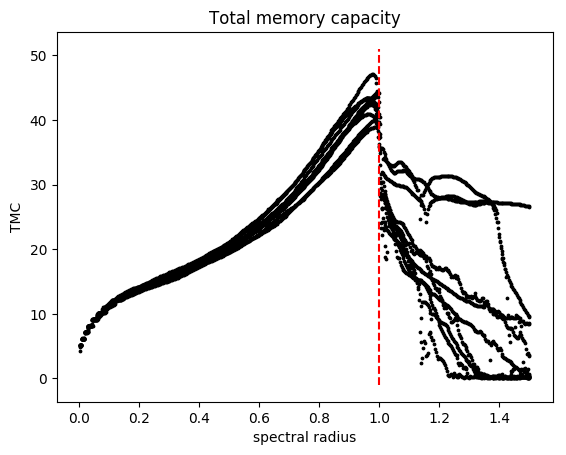

Info: L= 95 progress= 100.0 %


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001DAB5C88>

In [39]:
# PARAMETERS

dim_in = 1
dim_res = 100
T = 1100
L = 95
sparsity = 0.9999999
ρmin = 0
ρmax = 1.5

N = 500
epochs = 10

#GO!
for ep = 1:epochs
    println("Starting epoch: ",ep)
    
    #for sparsity = 0.999999:-0.01:0.809999
    #for l = 30:5:L
        
        # INITIALISATION
        data = 2*rand(T,1) - 1
        W_in = 0.01*(2*rand(dim_res,dim_in) - 1)
        W_res0 = np.array(sprandn(dim_res, dim_res, sparsity))
        W, ρ1 = initWres(W_res0, 1)

        TMC_arr = zeros(N)
        Err_arr = zeros(N)
        ρ_arr = zeros(N)

        for i = 1:N
            # Distribution ρmin -> ρmax
            scale = ( i/N * (ρmax - ρmin) + ρmin )/ ρ1
            W_res, ρ_arr[i] = initWres(W_res0, scale)

            r = zeros(dim_res)

            # CLEANSING
            r, R = echo(dim_res, data[1:100], r, W_in, W_res)

            # TRAINING
            r, R = echo(dim_res, data[101:600], r, W_in, W_res)

            D = output(L,data,101,600)
            W_out = pinv(R) * D

            # TESTING
            r, R = echo(dim_res, data[601:1100], r, W_in, W_res)

            D = output(L,data,601,1100)
            Y = R * W_out
            MC, TMC = totmem(D,Y)
            Err = error(D,Y)/(L*500)

            TMC_arr[i] = TMC
            Err_arr[i] = Err

            if i%100 == 0
                println("Info: L= ",L, " progress= ", 100*i/N, " %")
            end
        end
    scatter(ρ_arr, TMC_arr, s=3, color="black")
end
title("Total memory capacity")
xlabel("spectral radius")
ylabel("TMC")
plot((1, 1), (-1, 51), "r--");
#savefig("MC.pdf")